# Use Graph Builder to create a dynamic workflow

## Introduction
In this tutorial, you will learn how to use `Graph Builder` in WorkGraph. The `Graph Builder` allow user to create a dynamic workflow based on the input value, as well as nested workflows.

Load the AiiDA profile.

In [1]:
%load_ext aiida
from aiida import load_profile
load_profile()

Profile<uuid='57ccbf7d9e2b41b39edb2bfdaf725feb' name='default'>

## Workflow
Suppose we want to WorkGraph which include another WorkGraph`(x+y)*z` inside it.

### Create graph builder
We add `task.graph_builder` decorator to a function to define a graph builder task. The function create a WorkGraph based on the inputs, and returns the WorkGraph at the end.


#### Expose outputs
We can expose the outputs of the tasks as the outputs of the WorkGraph:
```python
@task.graph_builder(outputs = [{"name": "multiply", "from": "multiply.result"}])
```
This will expose the `result` output of the `multiply` task as the `multiply` output of the WorkGraph.


```python
@task.graph_builder(outputs = [{"name": "multiply", "from": "multiply"}])
```

This will expose whole outputs of the `multiply` task as the `multiply` output of the WorkGraph.

In [3]:
from aiida_workgraph import task, WorkGraph

# define add task
@task.calcfunction()
def add(x, y):
    return x + y

# define multiply task
@task.calcfunction()
def multiply(x, y):
    return x*y


# use task.graph_builder decorator, expose the output of "multiply" task
# as the output of the `WorkGraph`.
@task.graph_builder(outputs = [{"name": "multiply", "from": "multiply.result"}])
def add_multiply(x, y, z):
    # Create a WorkGraph
    wg = WorkGraph()
    wg.add_task(add, name="add", x=x, y=y)
    wg.add_task(multiply, name="multiply", x=z)
    wg.add_link(wg.tasks["add"].outputs[0], wg.tasks["multiply"].inputs["y"])
    # don't forget to return the `wg`
    return wg

### Create nested workflow
We can use the graph builder task inside another WorkGraph to create nested workflow. Here is an example:

In [3]:

from aiida_workgraph import WorkGraph
from aiida.orm import Int

wg = WorkGraph("test_graph_build")
# create a task using the graph builder
add_multiply1 = wg.add_task(add_multiply, x=Int(2), y=Int(3), z=Int(4))
add_multiply2 = wg.add_task(add_multiply, x=Int(2), y=Int(3))
# link the output of a task to the input of another task
wg.add_link(add_multiply1.outputs[0], add_multiply2.inputs["z"])
wg.submit(wait=True)
assert add_multiply2.outputs[0].value == 100
wg.to_html()

WorkGraph process created, PK: 87577


Generate node graph from the AiiDA process,and we can see that the `multiply` task is executed.

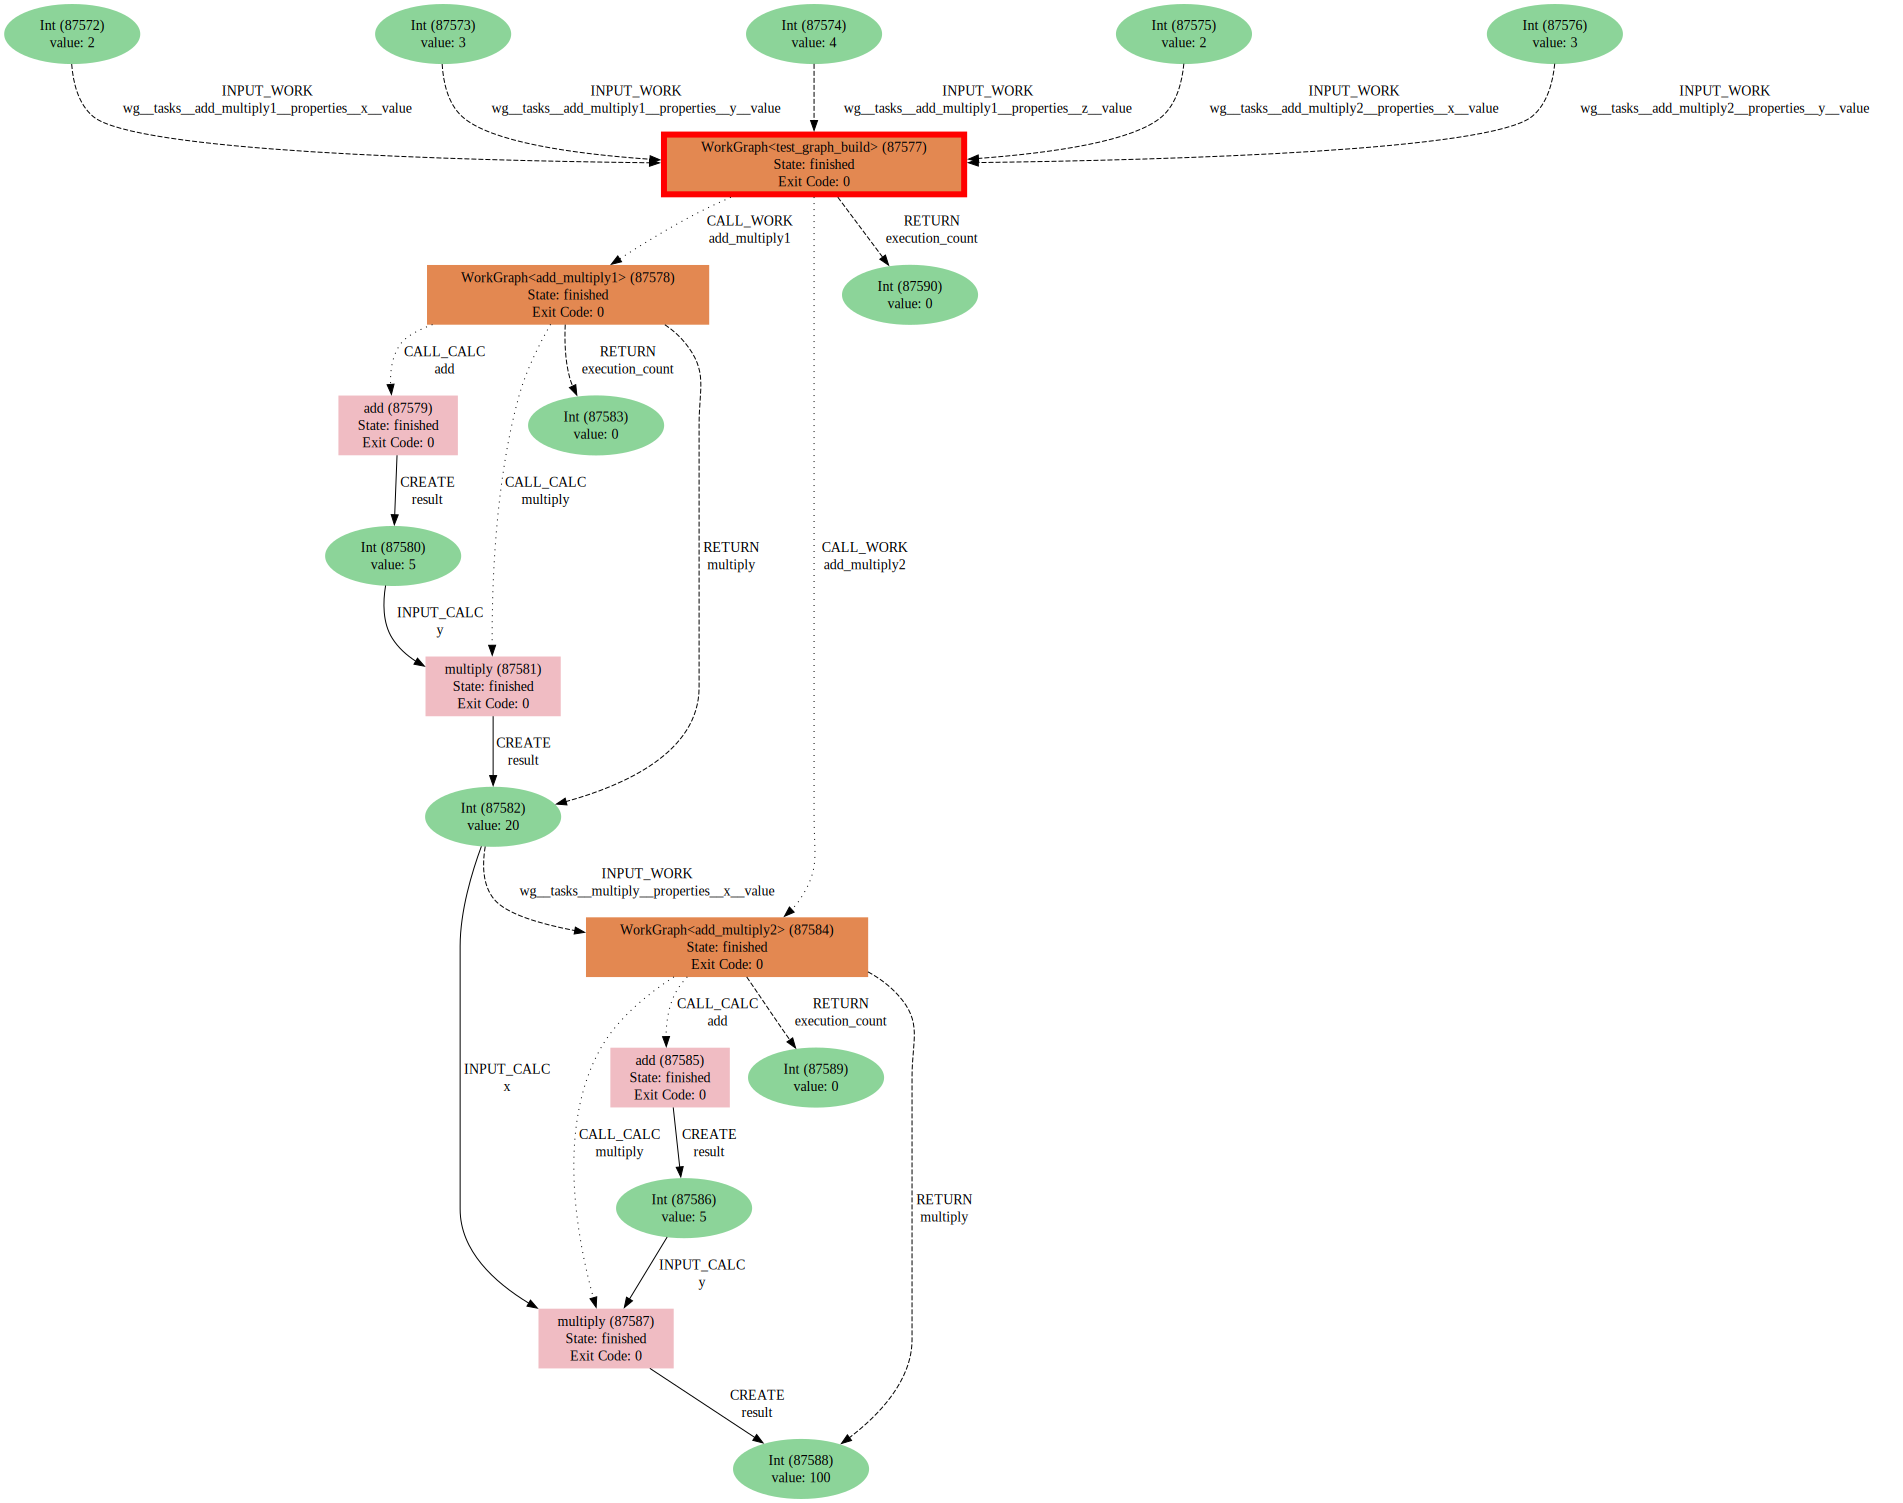

In [4]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

### Use the graph builder directly
Of course, one can use the graph builder directly to create a WorkGraph. Here is an example:

In [5]:
wg = add_multiply(2, 3, 4)
wg.submit(wait=True)

WorkGraph process created, PK: 87321


<WorkChainNode: uuid: 424852cb-22ec-4f79-b99b-22d2904b160c (pk: 87321) (aiida_workgraph.engine.workgraph.WorkGraphEngine)>

### Create the a Task from the workgraph (Experimental)
One can create a Task from a WorkGraph directly.

In [4]:

from aiida_workgraph import WorkGraph

wg1 = WorkGraph()
# note, one can not set the inputs values here using AiiDA data types
wg1.add_task(add, name="add")
wg1.add_task(multiply, name="multiply")
wg1.add_link(wg1.tasks["add"].outputs[0], wg1.tasks["multiply"].inputs["y"])

NodeLink(from="add.result", to="multiply.y")

Then we can use this `wg1` inside a WorkGraph. The inputs and outputs of all tasks in `wg1` will be exposed as the inputs and outputs of the task.

In [5]:
wg2 = WorkGraph("test_graph_build")
# create a task using the graph builder
add_multiply1 = wg2.add_task(wg1, name="add_multiply1")
add_multiply2 = wg2.add_task(wg1, name="add_multiply2")
# link the output of a task to the input of another task
wg2.add_link(add_multiply1.outputs["multiply.result"], add_multiply2.inputs["add.x"])


# create a task using the WorkGraph
print("Inputs:")
for input in add_multiply1.inputs:
    print(f"  - {input.name}")
print("Outputs:")
for output in add_multiply1.outputs:
    print(f"  - {output.name}")

wg2.to_html()

Inputs:
  - add
  - add.metadata
  - add.metadata.store_provenance
  - add.metadata.description
  - add.metadata.label
  - add.metadata.call_link_label
  - add.metadata.disable_cache
  - add.x
  - add.y
  - multiply
  - multiply.metadata
  - multiply.metadata.store_provenance
  - multiply.metadata.description
  - multiply.metadata.label
  - multiply.metadata.call_link_label
  - multiply.metadata.disable_cache
  - multiply.x
  - multiply.y
  - _wait
Outputs:
  - add
  - add.result
  - multiply
  - multiply.result
  - _outputs
  - _wait


Prepare the inputs and run the WorkGraph:

In [6]:
from aiida.orm import Int

add_multiply1.set({"add": {"x": Int(2), "y": Int(3)}, "multiply": {"x": Int(4)}})
add_multiply2.set({"add": {"y": Int(4)}, "multiply": {"x": Int(3)}})

wg2.submit(wait=True)


WorkGraph process created, PK: 89797


<WorkChainNode: uuid: 50143453-822f-447b-ba17-9dd76e8a1adf (pk: 89797) (aiida_workgraph.engine.workgraph.WorkGraphEngine)>

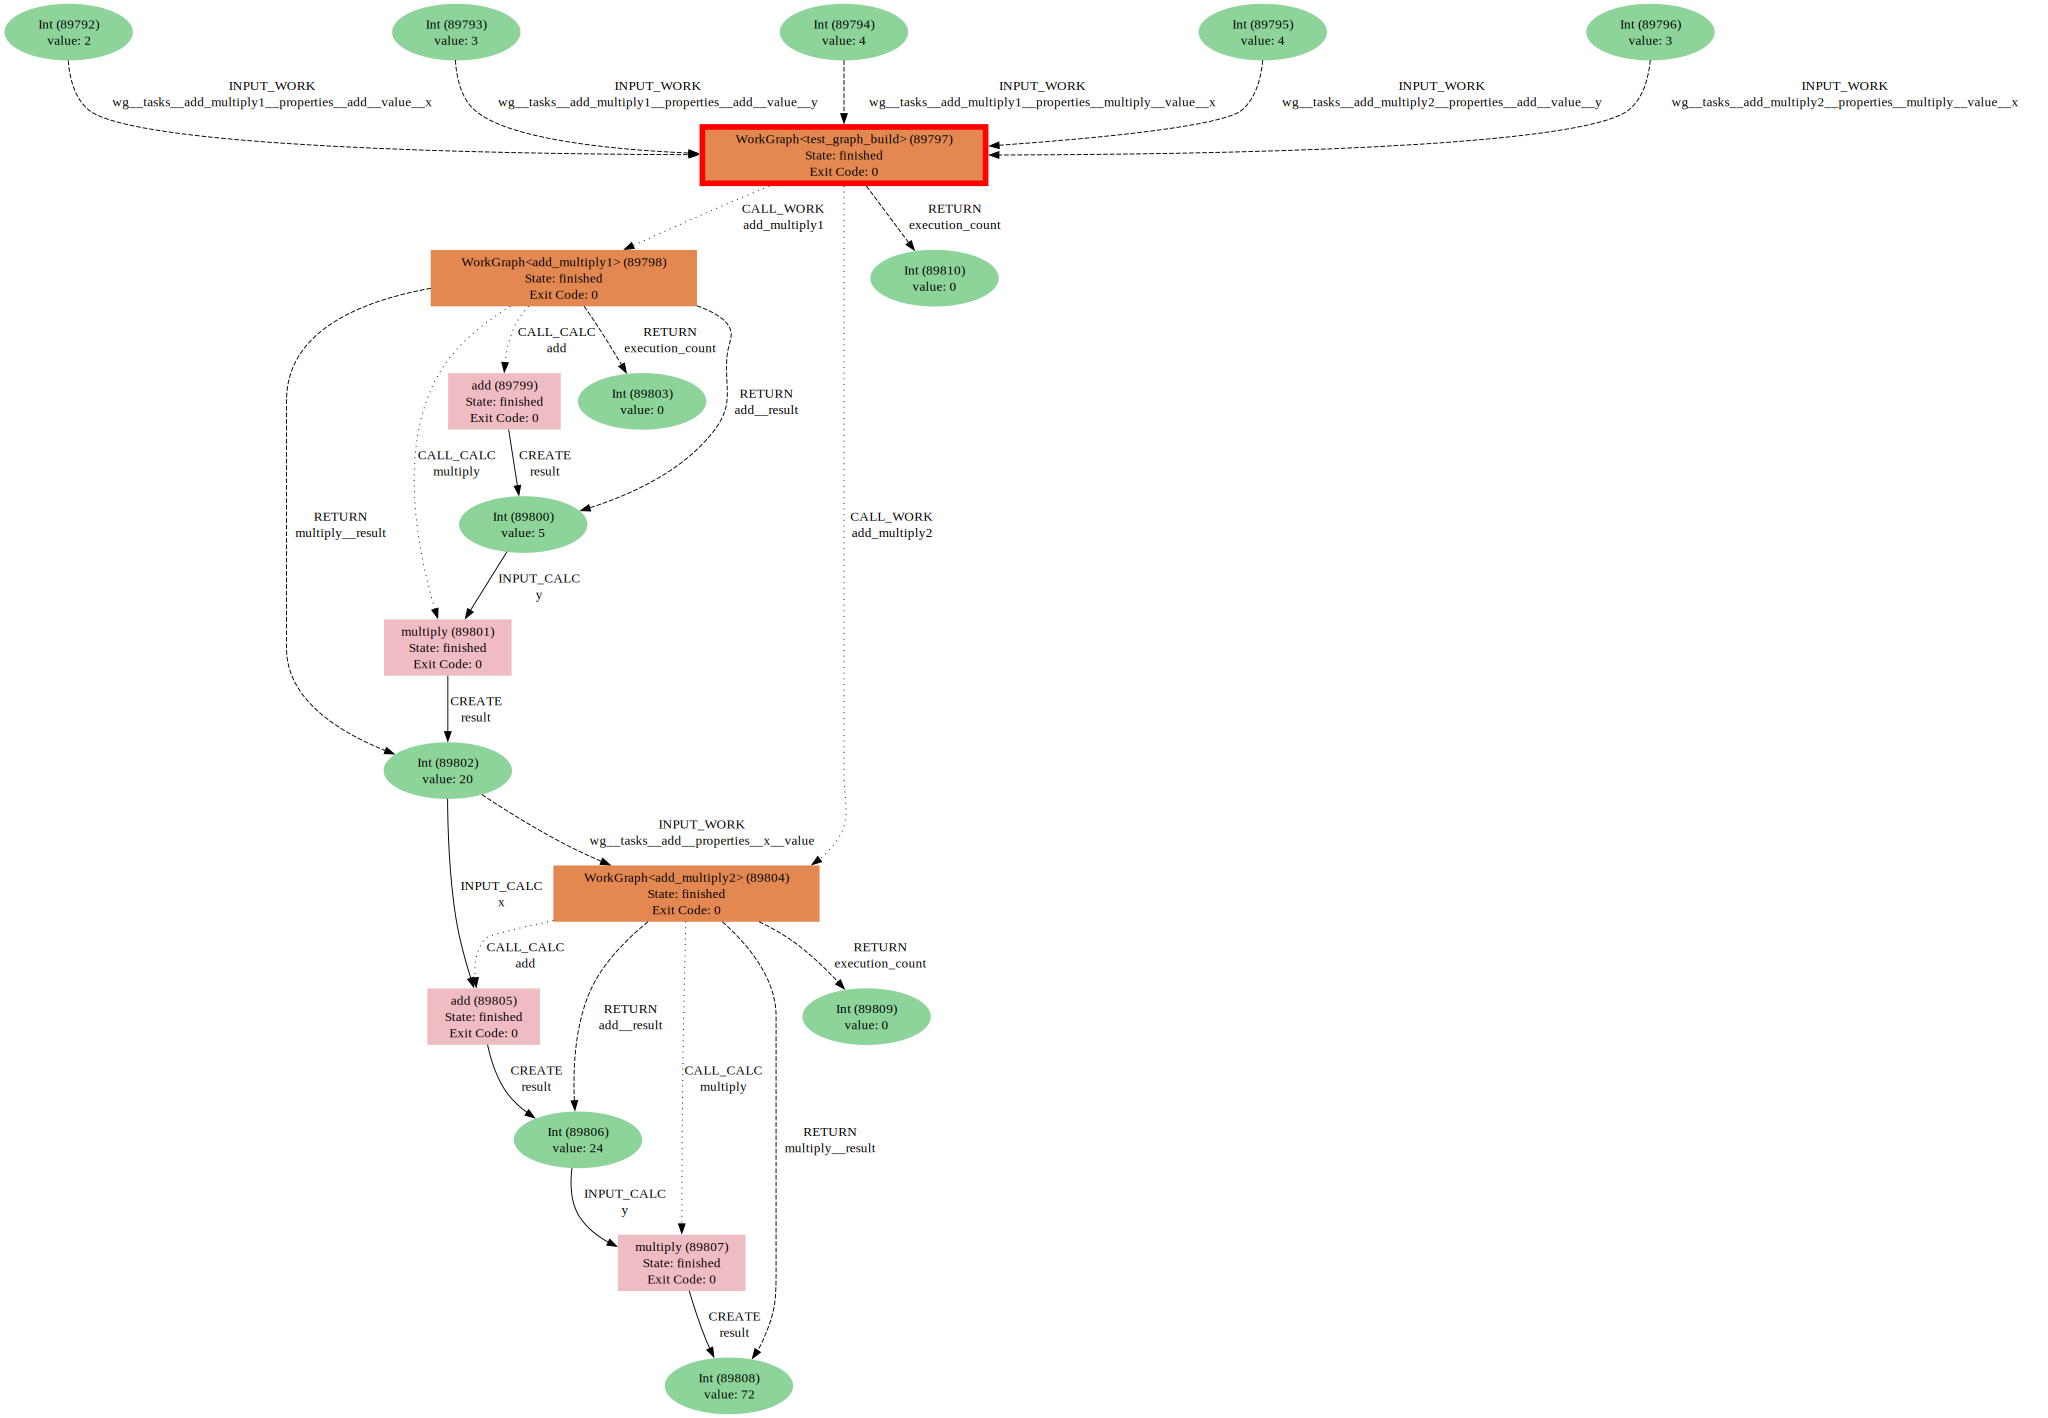

In [7]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg2.pk)

More usage (like `if` and `while`) of graph builder will be shown in the following tutorials.